In [2]:
# process data and save to memory as variables, not storage
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2023-08-01 12:09:24.839820: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 12:09:24.871809: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 12:09:25.012040: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 12:09:25.013022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 12:09:27.100149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
wireplane='U'

In [4]:
# takes full raw data and extracts waveform of length nticks
def extract_wave(data, nticks=200):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

# takes full raw data and returns waveform of length nticks
# only keeps waves at a desired adc count 
def get_std_waveforms(data_noisy, data_clean, nticks=200, min_adc=5):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms_noisy = extract_wave(data_noisy, nticks)
    raw_waveforms_clean = extract_wave(data_clean, nticks)
    #print('before adc filter: ', raw_waveforms_noisy.shape, raw_waveforms_clean.shape)

    noisy_ = []
    clean_ = []

    for i, wave in enumerate(raw_waveforms_clean):
        if max(wave) >= min_adc:
            noisy_.append(raw_waveforms_noisy[i])
            clean_.append(wave)
    
    del raw_waveforms_noisy, raw_waveforms_clean

    noisy_ = np.array(noisy_)
    clean_ = np.array(clean_)

    #print('after adc filter: ', noisy_.shape, clean_.shape)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return noisy_, clean_



In [5]:
import tarfile
import os

# nuCC
dir_noisy_nu_cc = '/home/vlian/Workspace/train_dune_lartpc_v2/nu_cc/'+wireplane+'/noisy_signal/'  # Directory to extract files
dir_clean_nu_cc = '/home/vlian/Workspace/train_dune_lartpc_v2/nu_cc/'+wireplane+'/clean_signal/'  # Directory to extract files

noisy_names_cc = os.listdir(dir_noisy_nu_cc)
noisy_names_cc = sorted(noisy_names_cc)


clean_names_cc = os.listdir(dir_clean_nu_cc)
clean_names_cc = sorted(clean_names_cc)

# nuES
dir_noisy_nu_es = '/home/vlian/Workspace/train_dune_lartpc_v2/nu_es/'+wireplane+'/noisy_signal/'  # Directory to extract files
dir_clean_nu_es = '/home/vlian/Workspace/train_dune_lartpc_v2/nu_es/'+wireplane+'/clean_signal/'  # Directory to extract files

noisy_names_es = os.listdir(dir_noisy_nu_es)
noisy_names_es = sorted(noisy_names_es)

clean_names_es = os.listdir(dir_clean_nu_es)
clean_names_es = sorted(clean_names_es)


In [6]:
print(len(noisy_names_cc), len(clean_names_cc))
print(len(noisy_names_es), len(clean_names_es))

52 52
188 188


In [7]:
print(noisy_names_cc[0], '---', clean_names_cc[0])
print(noisy_names_es[0], '---', clean_names_es[0])

snb-nucc-en0-U-signal-67877023-0-0.npy --- snb-nucc-en0-U-clnsig-67877023-0-0.npy
snb-nues-en0-U-signal-101992-0-0.npy --- snb-nues-en0-U-clnsig-101992-0-0.npy


### seperate by energy

In [8]:
def get_wave_by_ENRG(energy_idx, noisy_filenames, clean_filenames, interaction_type=True):
    if interaction_type:
        noisy_path = dir_noisy_nu_cc
        clean_path = dir_clean_nu_cc
    else:
        noisy_path = dir_noisy_nu_es
        clean_path = dir_clean_nu_es

    file_names_noisy = [file for file in noisy_filenames if 'en'+str(energy_idx) in file ]
    file_names_clean = [file for file in clean_filenames if 'en'+str(energy_idx) in file ]

    noisy_waveforms = np.empty((0, 200))
    clean_waveforms = np.empty((0, 200))

    for i, file_name in enumerate(file_names_noisy):
        noisy_file_path = os.path.join(noisy_path, file_name)
        clean_file_path = os.path.join(clean_path, file_names_clean[i])
        

        noisy = np.load(noisy_file_path)
        clean = np.load(clean_file_path)

        noisy_wf, clean_wf = get_std_waveforms(noisy, clean, nticks=200, min_adc=5)
        
        noisy_waveforms = np.concatenate((noisy_waveforms, noisy_wf))
        clean_waveforms = np.concatenate((clean_waveforms, clean_wf))

    return [noisy_waveforms, clean_waveforms]


In [9]:
all_waveforms_nu_CC = []
all_waveforms_nu_ES = []
for i in range(10):
    all_waveforms_nu_CC.append(get_wave_by_ENRG(i, noisy_names_cc, clean_names_cc))
    all_waveforms_nu_ES.append(get_wave_by_ENRG(i, noisy_names_es, clean_names_es, False))

In [10]:
for i, en in enumerate(all_waveforms_nu_CC):
    print('en',i,':', 'nu_CC',en[0].shape, en[1].shape,'---','nu_ES', all_waveforms_nu_ES[i][0].shape, all_waveforms_nu_ES[i][1].shape)

en 0 : nu_CC (4479, 200) (4479, 200) --- nu_ES (7080, 200) (7080, 200)
en 1 : nu_CC (4377, 200) (4377, 200) --- nu_ES (6475, 200) (6475, 200)
en 2 : nu_CC (4701, 200) (4701, 200) --- nu_ES (6353, 200) (6353, 200)
en 3 : nu_CC (4869, 200) (4869, 200) --- nu_ES (6268, 200) (6268, 200)
en 4 : nu_CC (4828, 200) (4828, 200) --- nu_ES (6346, 200) (6346, 200)
en 5 : nu_CC (5891, 200) (5891, 200) --- nu_ES (6525, 200) (6525, 200)
en 6 : nu_CC (5745, 200) (5745, 200) --- nu_ES (6588, 200) (6588, 200)
en 7 : nu_CC (5919, 200) (5919, 200) --- nu_ES (6169, 200) (6169, 200)
en 8 : nu_CC (5991, 200) (5991, 200) --- nu_ES (6860, 200) (6860, 200)
en 9 : nu_CC (6809, 200) (6809, 200) --- nu_ES (6474, 200) (6474, 200)


### Load Noise

In [11]:
noise_path = '/home/vlian/Workspace/train_dune_lartpc_v2/noise/'+wireplane+'/'
noise_filenames = sorted([f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and wireplane in f)])
combined_noise = np.concatenate([np.load(noise_path+fname, mmap_mode='r') for fname in noise_filenames])

noise_waveforms = extract_wave(combined_noise)
roi_truth_noise = np.zeros(noise_waveforms.shape[0]) # for roi-finding
print(noise_waveforms.shape, roi_truth_noise.shape)

(100000, 200) (100000,)


### TEST

In [12]:
model_5_10_mean = np.load('../models_scales/mean_5_10' + wireplane + '_nu.npy')
model_5_10_std = np.load('../models_scales/scale_5_10' + wireplane + '_nu.npy')

model_5_15_mean = np.load('../models_scales/mean_5_15' + wireplane + '_nu.npy')
model_5_15_std = np.load('../models_scales/scale_5_15' + wireplane + '_nu.npy')

model_5_18_mean = np.load('../models_scales/mean_5_18' + wireplane + '_nu.npy')
model_5_18_std = np.load('../models_scales/scale_5_18' + wireplane + '_nu.npy')

model_60k_mean = np.load('../models_scales/mean_60k' + wireplane + '_nu.npy')
model_60k_std = np.load('../models_scales/scale_60k' + wireplane + '_nu.npy')

In [13]:
scalers = [[model_5_10_mean, model_5_10_std], [model_5_15_mean, model_5_15_std], 
           [model_5_18_mean, model_5_18_std], [model_60k_mean, model_60k_std]]

In [14]:
model_5_10 = load_model('../ROI_ar39_models/model_5_10' + wireplane + 'plane_nu_ROI.h5')

model_5_15 = load_model('../ROI_ar39_models/model_5_15' + wireplane + 'plane_nu_ROI.h5')

model_5_18 = load_model('../ROI_ar39_models/model_5_18' + wireplane + 'plane_nu_ROI.h5')

model_60k = load_model('../ROI_ar39_models/model_60k' + wireplane + 'plane_nu_ROI.h5')

In [15]:
models = [model_5_10, model_5_15, model_5_18, model_60k]

In [16]:
def eval_model(idx, cnn_min):
    model_idx = idx

    noise_scaled = (noise_waveforms-scalers[model_idx][0])/scalers[model_idx][1]
    infer = models[model_idx].predict(noise_scaled, verbose=0)
    
    return (len([i for i in infer if i > cnn_min])/len(infer))*100

In [17]:
for i in range(4):
    print(round(eval_model(i, 0.999), 5), round(eval_model(i, 0.94), 5))

100.0 99.514
99.995 99.456
99.997 99.609
99.997 99.735


In [18]:
def eval_model_en(en_group_waveforms, model_idx, cnn_min):

    waveforms_scaled = (en_group_waveforms-scalers[model_idx][0])/scalers[model_idx][1]
    infer = models[model_idx].predict(waveforms_scaled, verbose=0)
    
    return (len([i for i in infer if i > cnn_min])/len(infer))*100

In [19]:
for i, signals_at_en in enumerate(all_waveforms_nu_ES):
    print('en:', i)
    for j in range(4):
        #print('    model:', j)
        print(round(eval_model_en(signals_at_en[0], j, 0.999), 2), round(eval_model_en(signals_at_en[0], j, 0.94), 2))
    print('--------------')

en: 0
82.64 90.4
84.22 90.51
84.05 89.92
83.69 89.36
--------------
en: 1
83.03 90.5
84.71 90.61
84.28 90.02
83.97 89.54
--------------
en: 2
83.5 90.57
84.98 90.52
84.73 90.15
84.46 89.74
--------------
en: 3
83.14 89.95
84.65 90.3
84.41 89.69
84.16 89.26
--------------
en: 4
84.31 90.56
85.79 90.8
85.61 90.28
85.36 89.68
--------------
en: 5
84.21 90.24
85.66 90.39
85.29 89.76
85.09 89.47
--------------
en: 6
82.64 89.09
83.93 89.36
83.67 88.8
83.47 88.39
--------------
en: 7
83.53 89.84
84.91 90.03
84.58 89.63
84.37 89.14
--------------
en: 8
83.38 89.49
84.71 89.84
84.48 89.27
84.21 88.72
--------------
en: 9
83.84 89.17
84.94 89.51
84.69 89.02
84.51 88.52
--------------


### Denoising Autoencoder

In [20]:
model_5_10_AE = load_model('../AE_ar39_models/model_5_10' + wireplane + 'plane_nu_AE.h5')

model_5_15_AE = load_model('../AE_ar39_models/model_5_15' + wireplane + 'plane_nu_AE.h5')

model_5_18_AE = load_model('../AE_ar39_models/model_5_18' + wireplane + 'plane_nu_AE.h5')

model_60k_AE = load_model('../AE_ar39_models/model_60k' + wireplane + 'plane_nu_AE.h5')

In [40]:
model_AE_check = load_model('../../../archive/AutoEncoder-Current/models/model_AE_2048_no_poolingUplane_nu.h5')
mean_check = np.load('../../../archive/AutoEncoder-Current/models/mean_AE_np_U.npy')
std_check = np.load('../../../archive/AutoEncoder-Current/models/std_AE_np_U.npy')

In [45]:
def roi_ae(data_set, energy, roi_model, ae_model, roi_scalers, ae_scalers, num_pred):
    waveform_noisy = data_set[energy][0]
    noisy_wave_scaled_ROI = (waveform_noisy-roi_scalers[0])/roi_scalers[1]
    noisy_wave_scaled_AE = (waveform_noisy-ae_scalers[0])/ae_scalers[1]
    
    waveform_clean = data_set[energy][1]
    clean_wave_scaled = (waveform_clean-ae_scalers[0])/ae_scalers[1]
    counter = 0
    for i in range(100000):
        wave_roi = noisy_wave_scaled_ROI[i:i+1]
        if roi_model.predict(wave_roi, verbose=0) > 0.999:
            wave_AE = noisy_wave_scaled_AE[i:i+1]
            ae_pred = ae_model(wave_AE)
            pred = ae_pred*ae_scalers[1] + ae_scalers[0]
            
            fig = plt.figure(figsize=(8,2))
            plt.plot(pred[0], color='m', label='pred')
            plt.plot(waveform_clean[i:i+1][0], color='blue', label='target')
            plt.legend()
            plt.show()
            
            counter += 1
            
            if counter >= num_pred:
                break

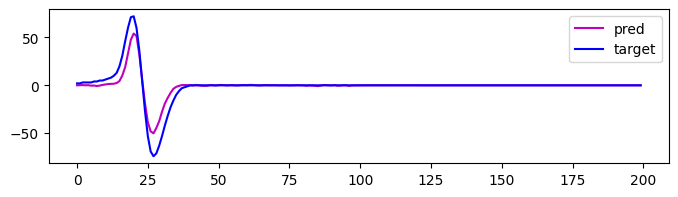

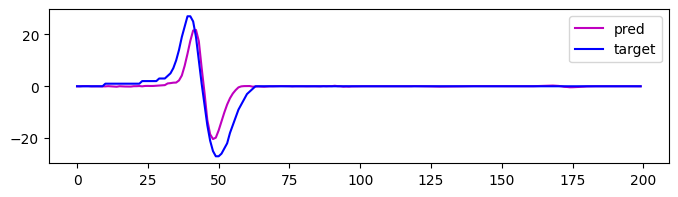

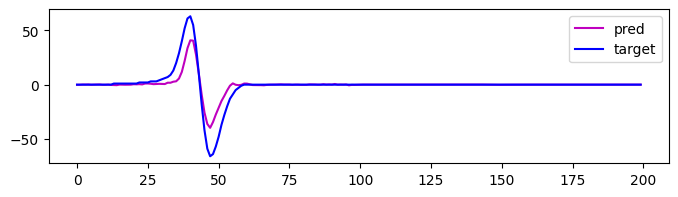

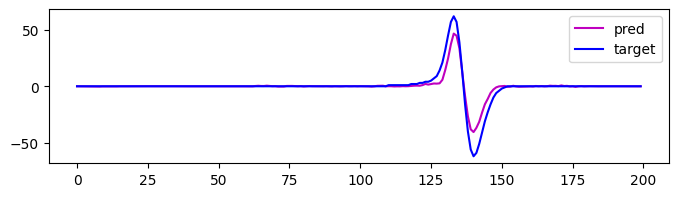

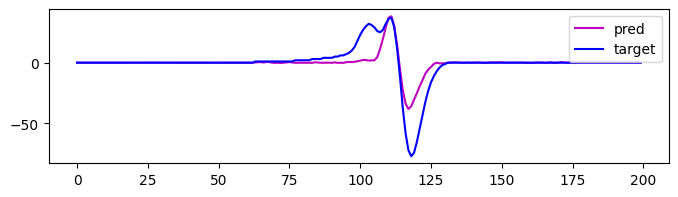

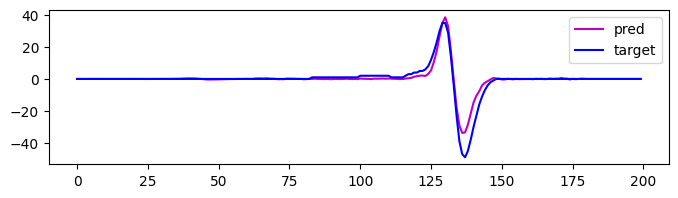

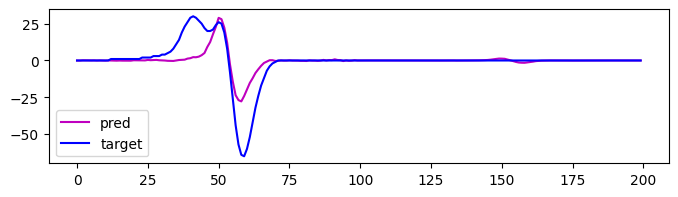

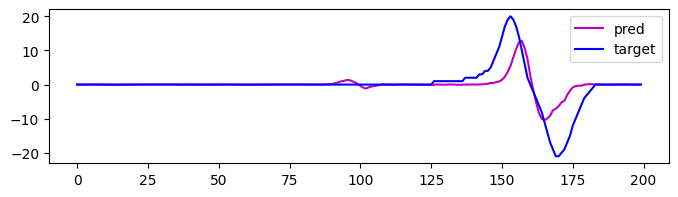

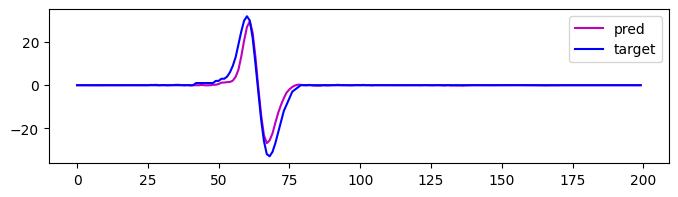

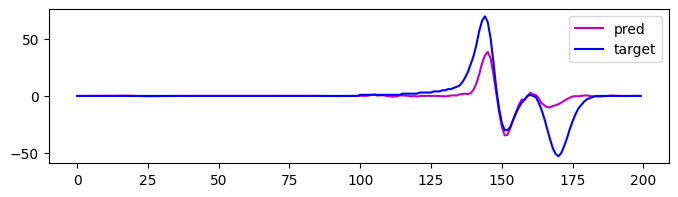

In [46]:
roi_ae(all_waveforms_nu_ES, 0,model_60k, model_60k_AE, [model_60k_mean, model_60k_std], [model_60k_mean, model_60k_std],10)

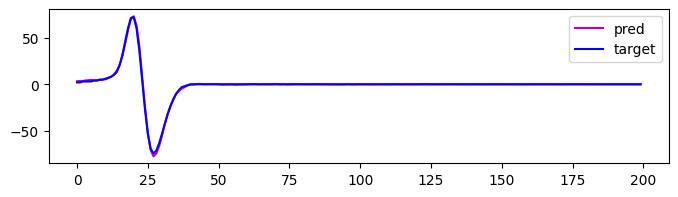

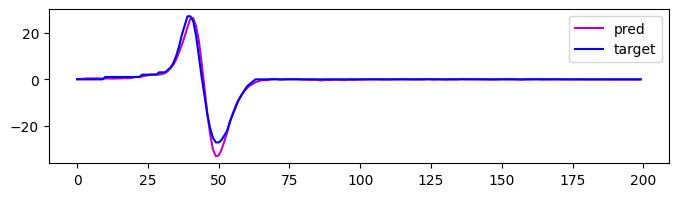

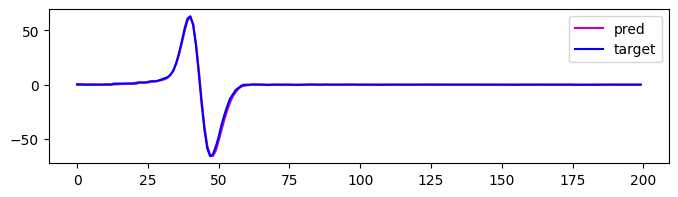

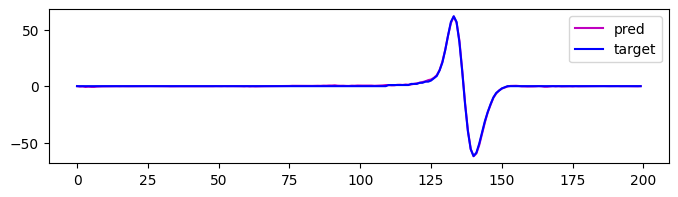

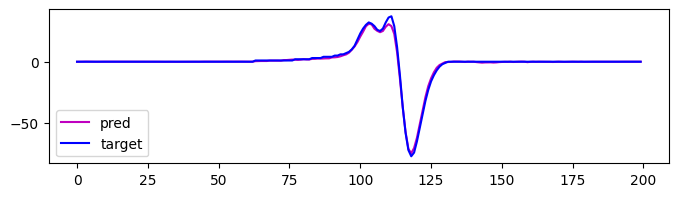

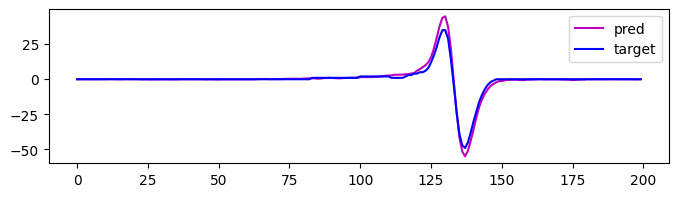

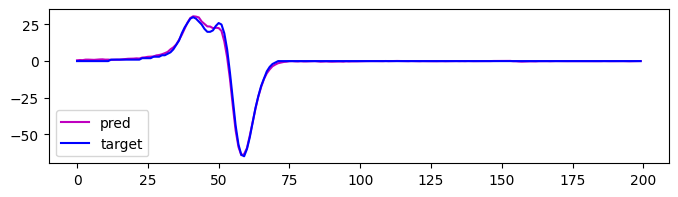

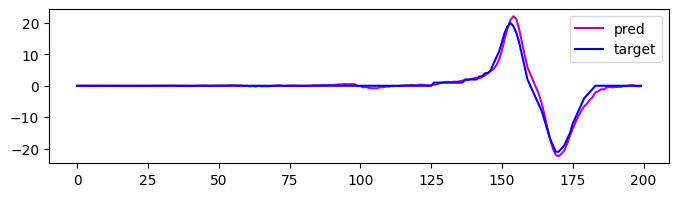

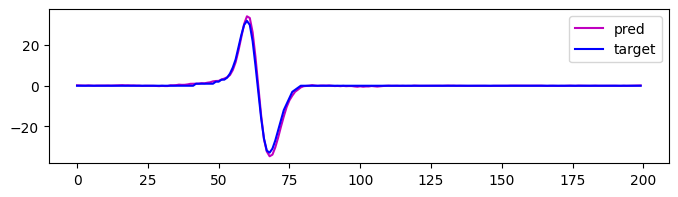

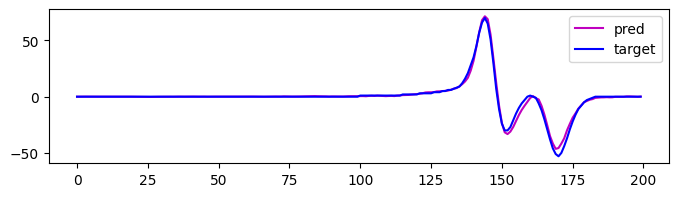

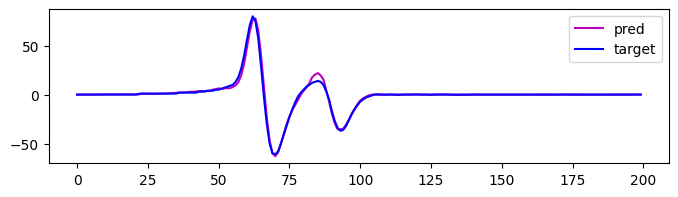

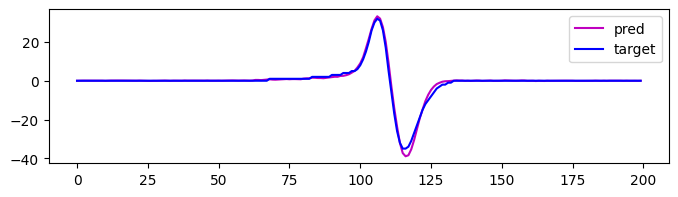

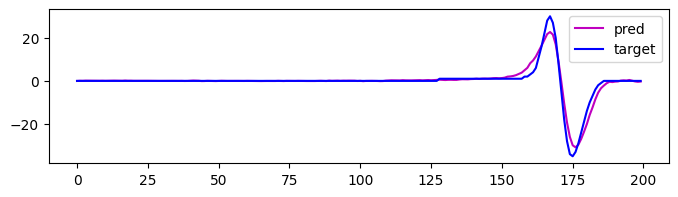

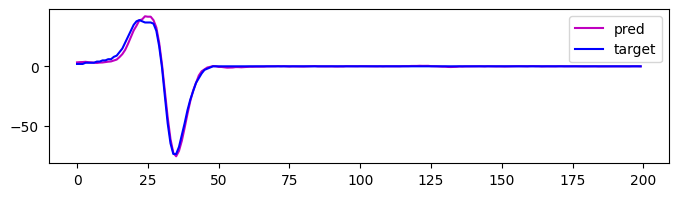

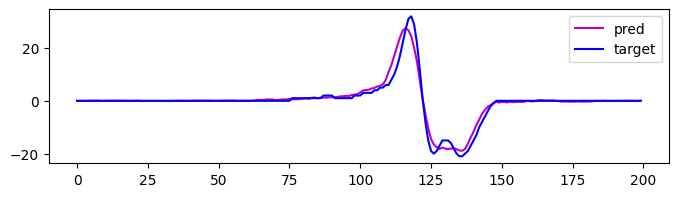

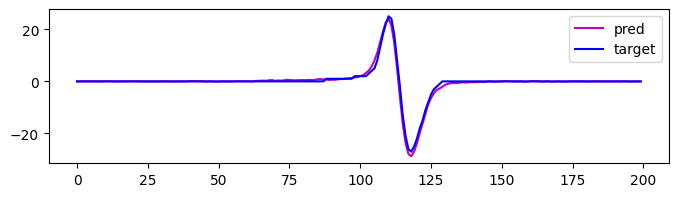

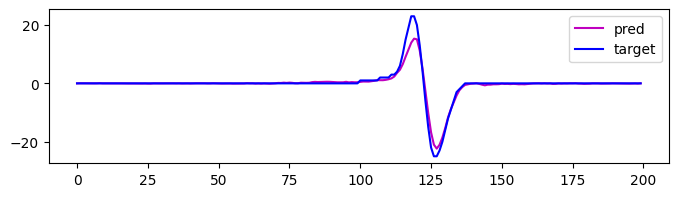

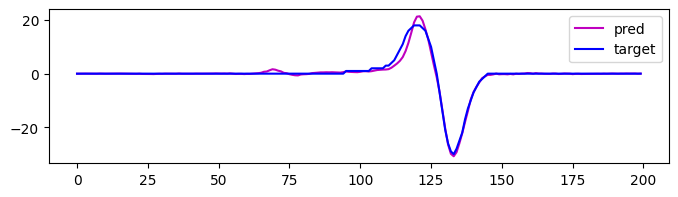

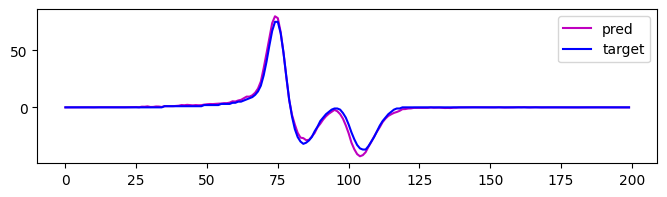

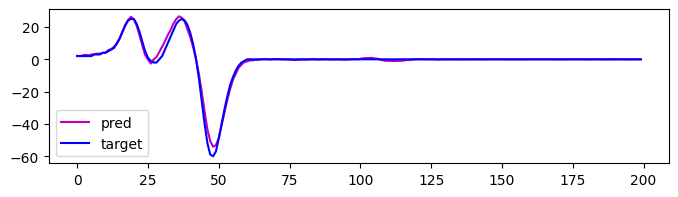

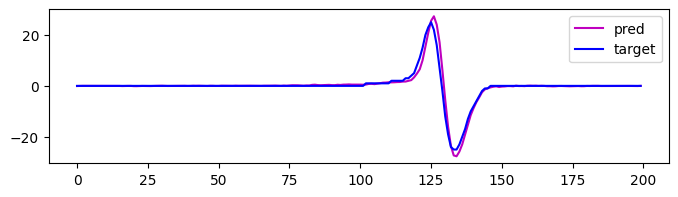

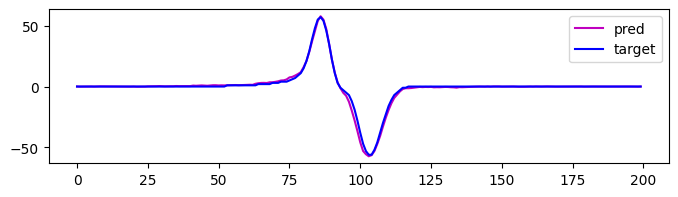

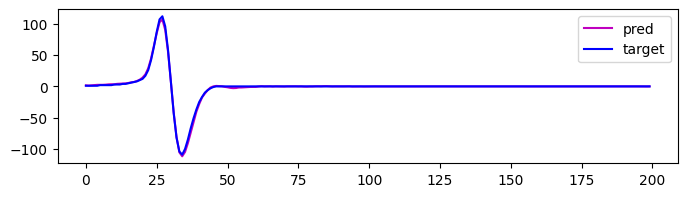

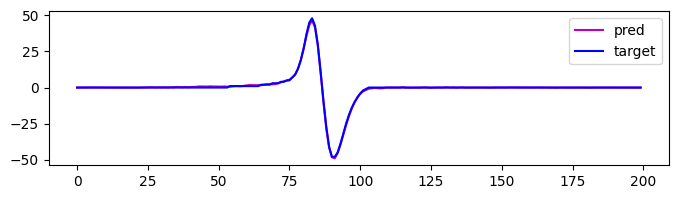

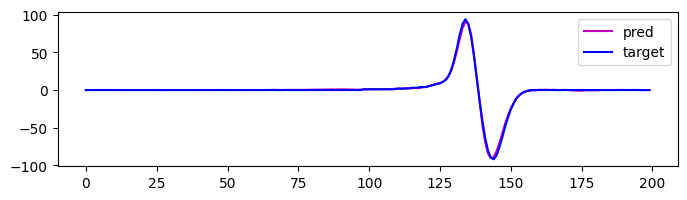

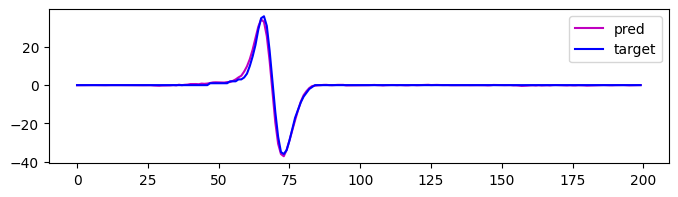

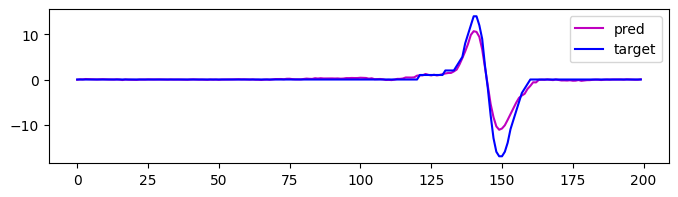

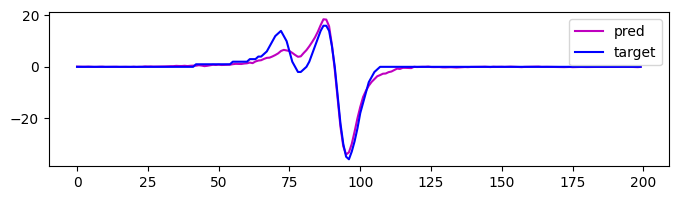

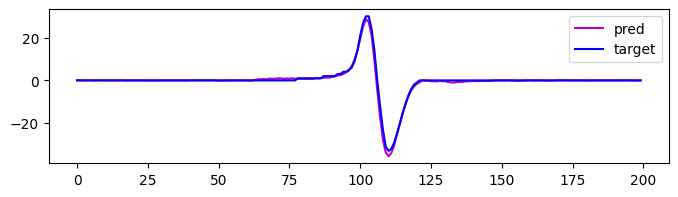

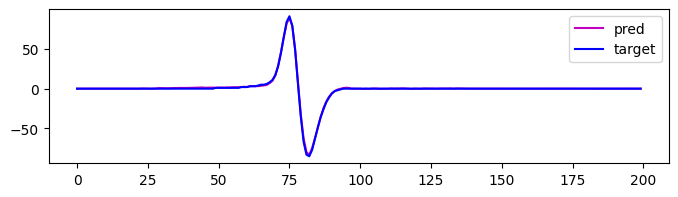

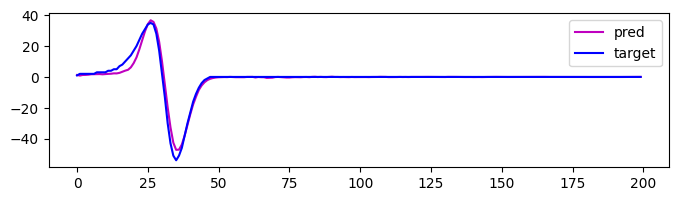

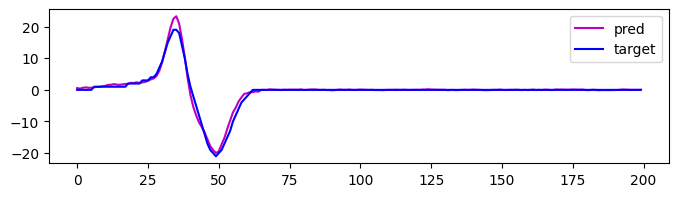

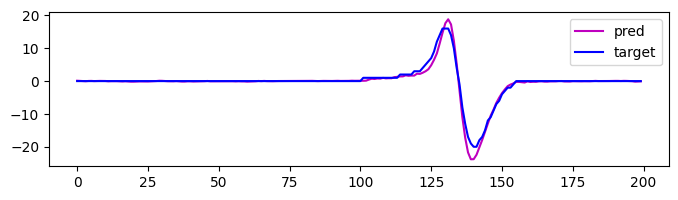

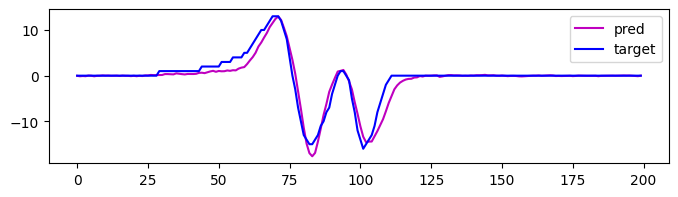

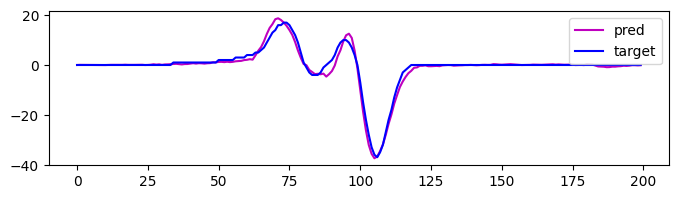

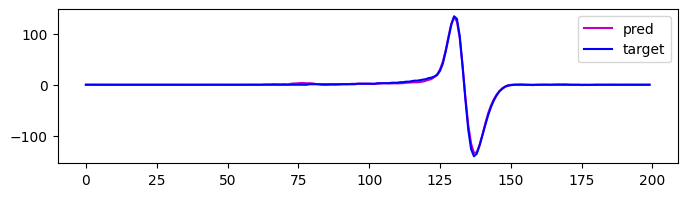

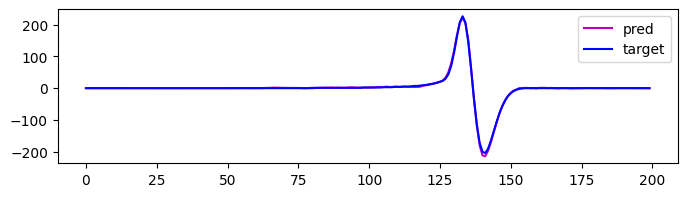

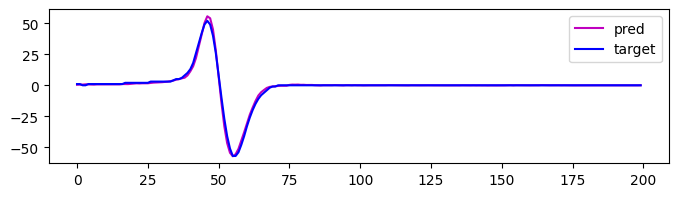

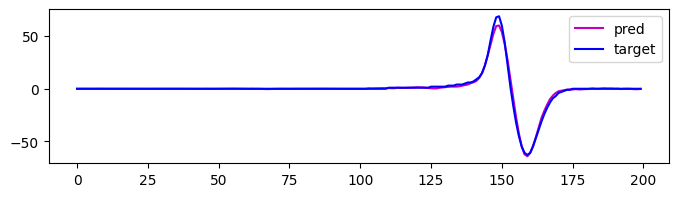

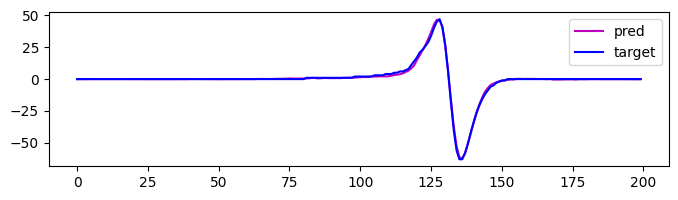

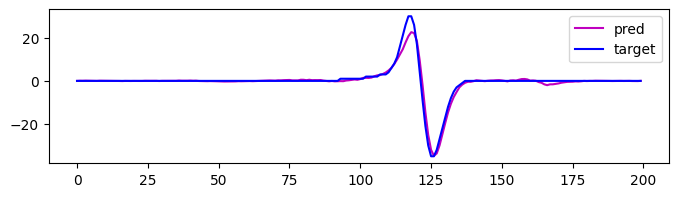

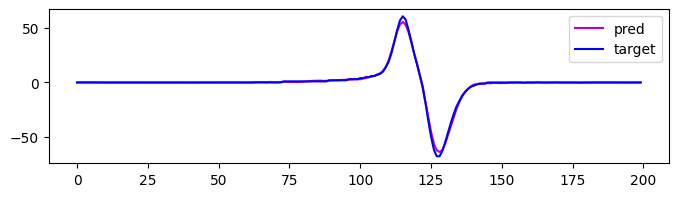

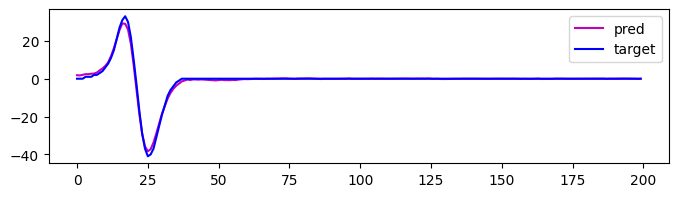

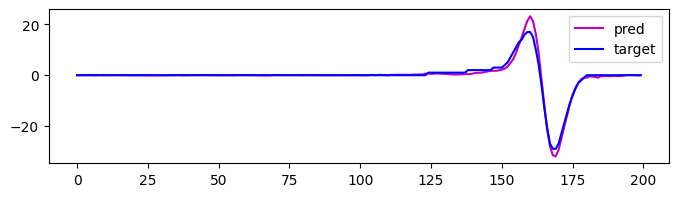

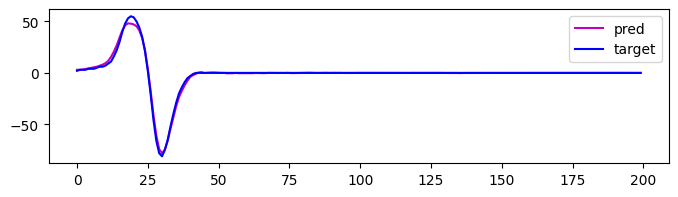

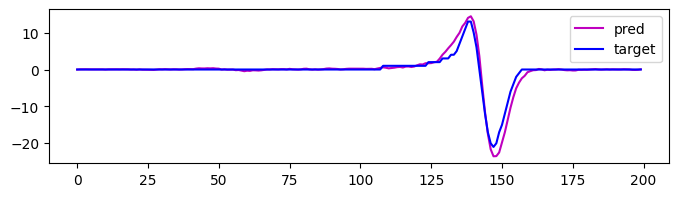

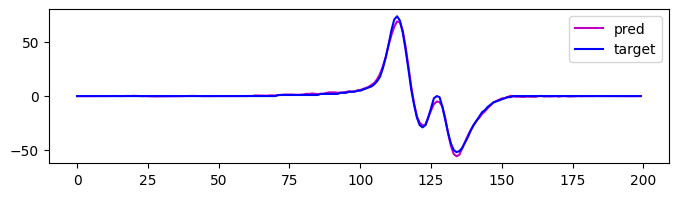

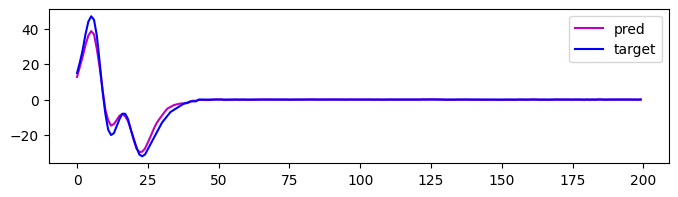

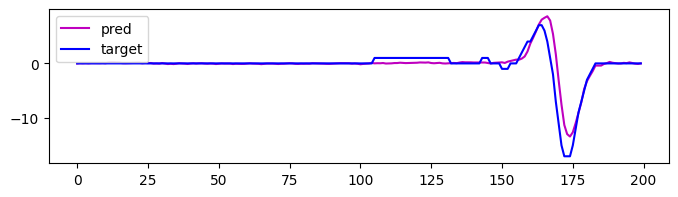

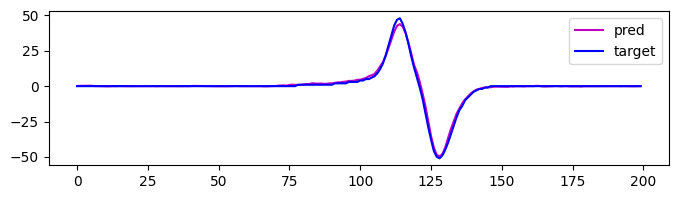

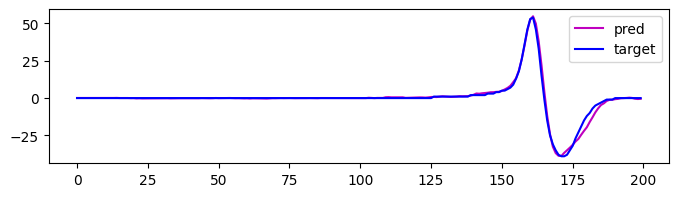

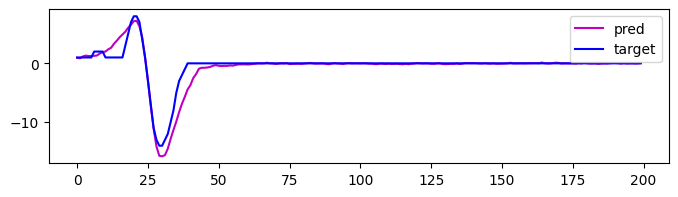

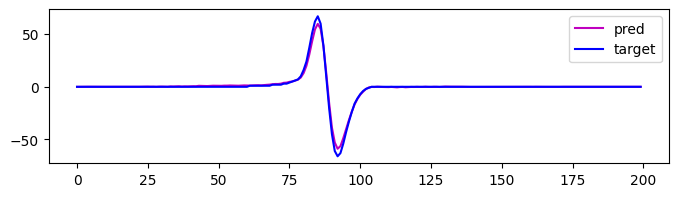

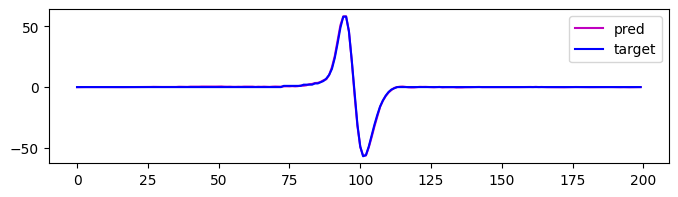

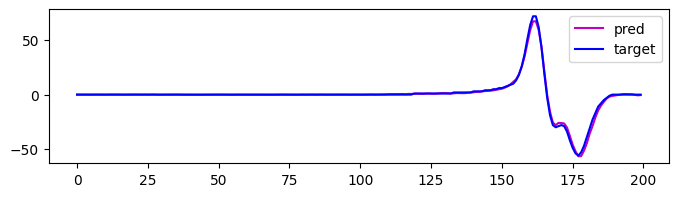

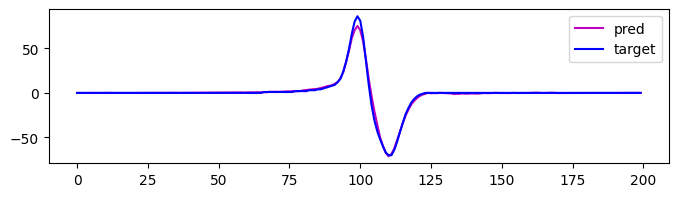

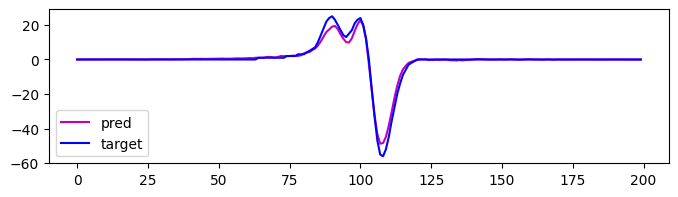

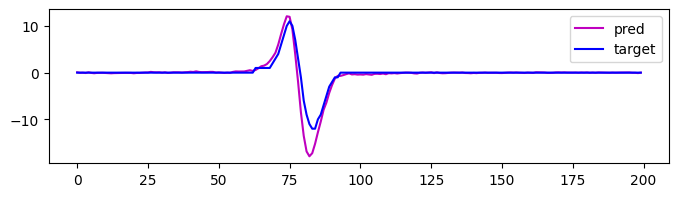

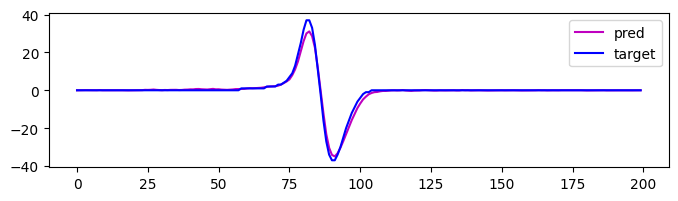

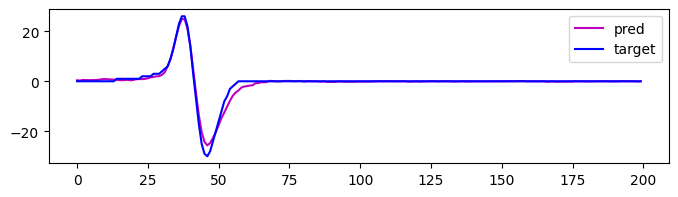

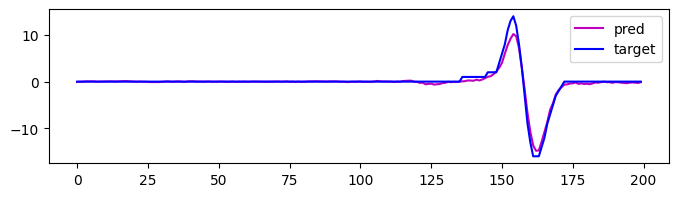

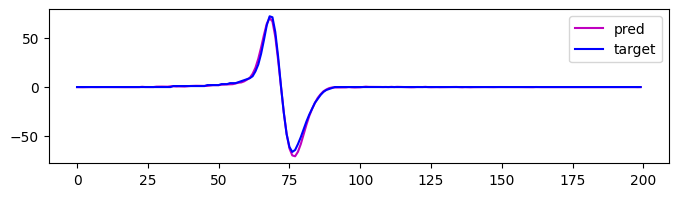

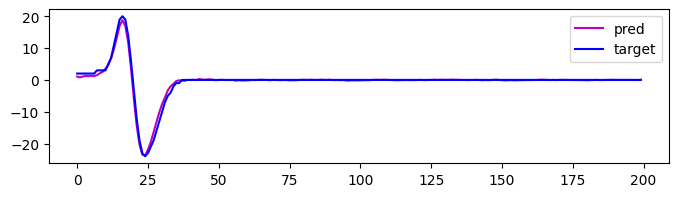

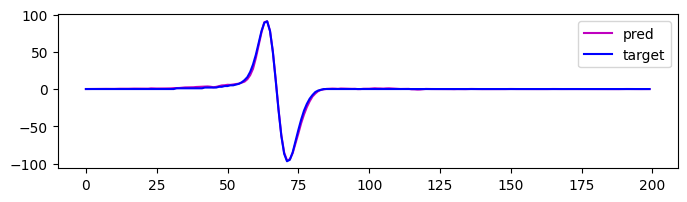

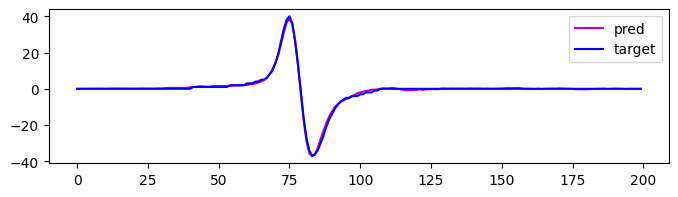

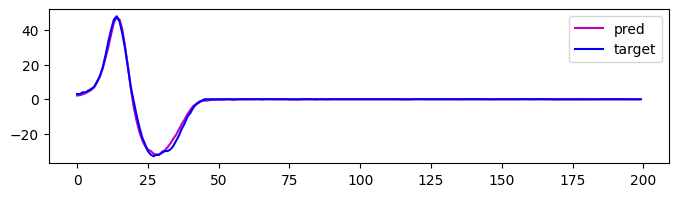

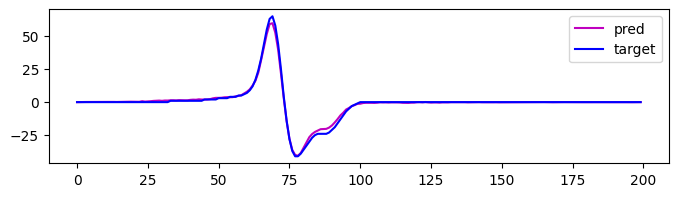

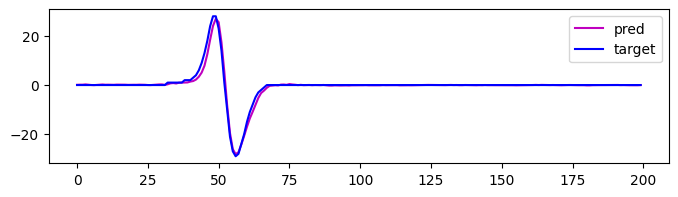

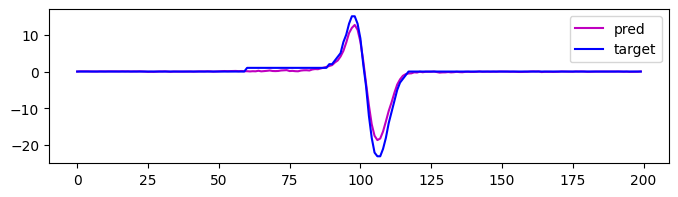

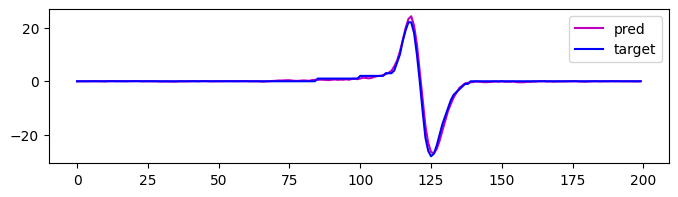

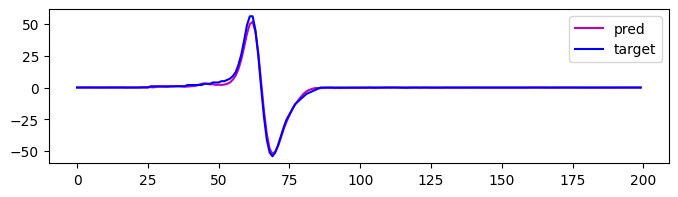

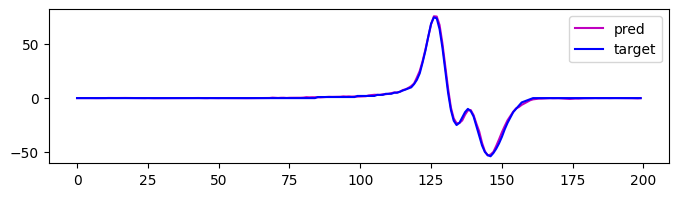

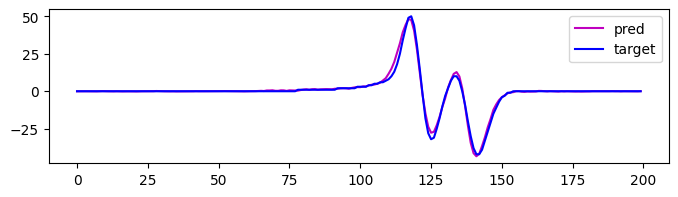

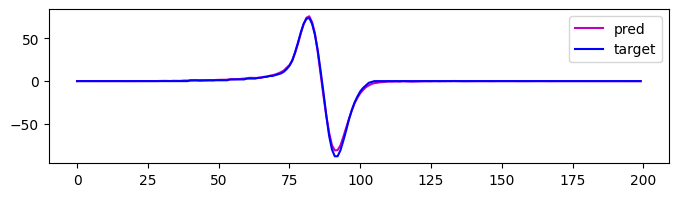

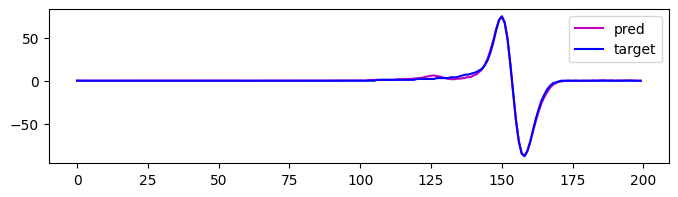

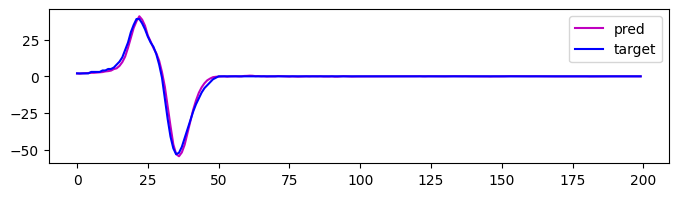

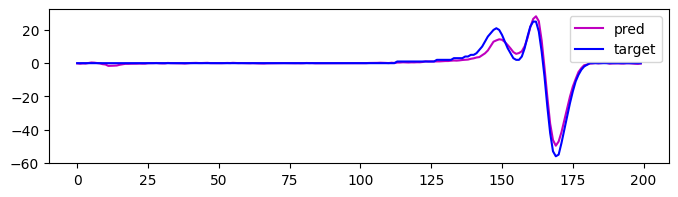

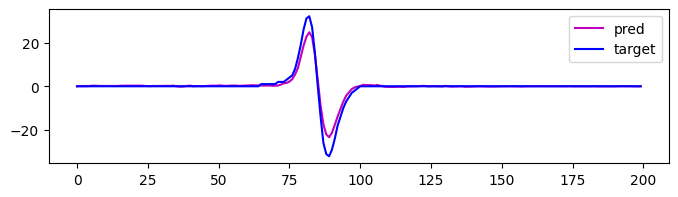

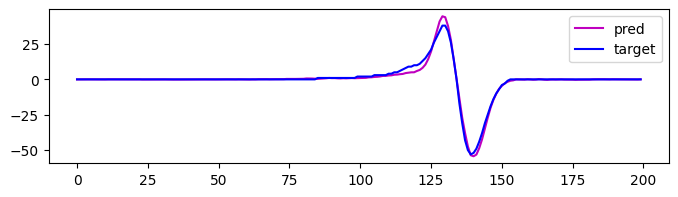

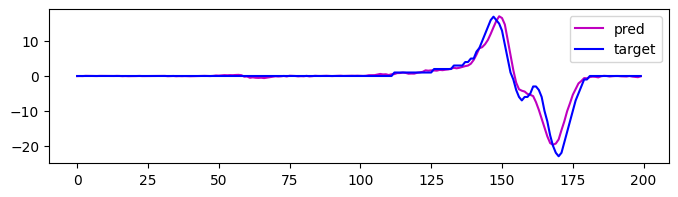

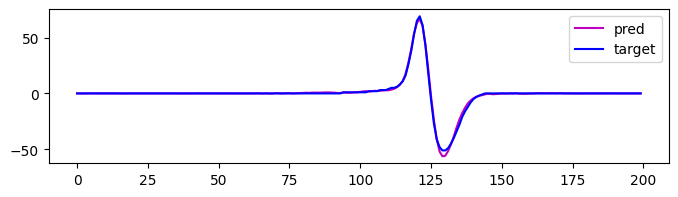

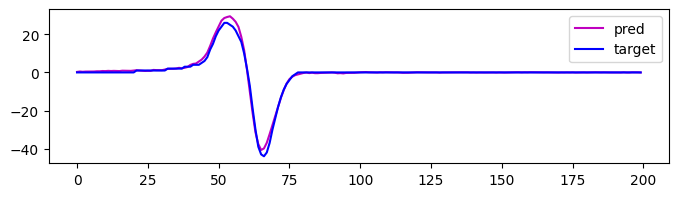

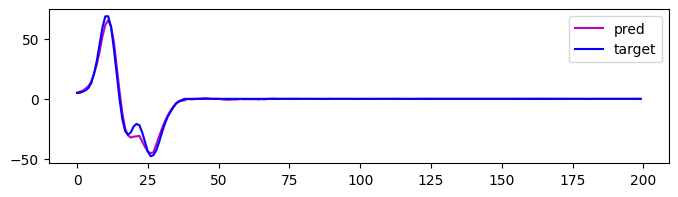

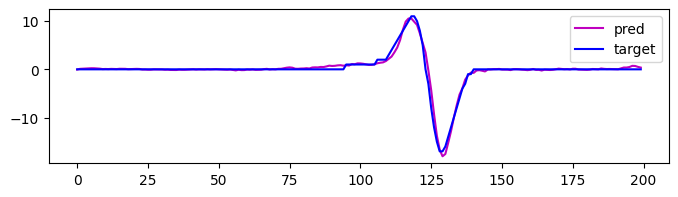

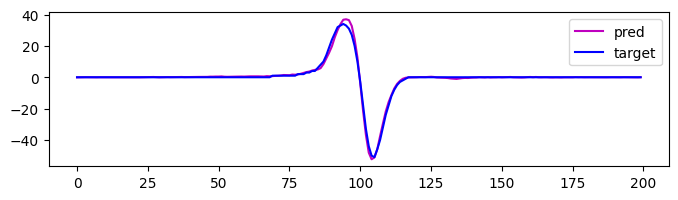

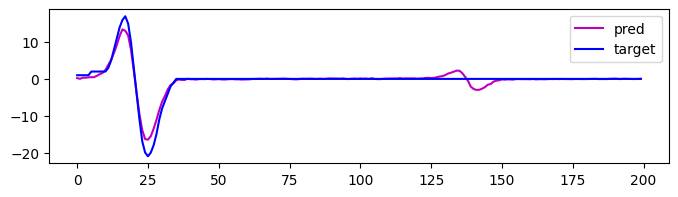

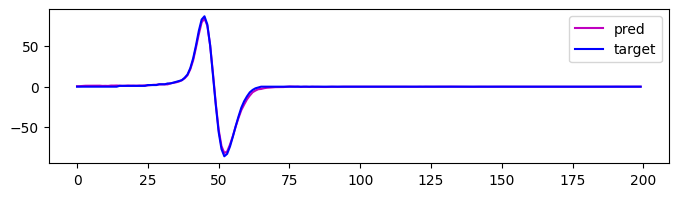

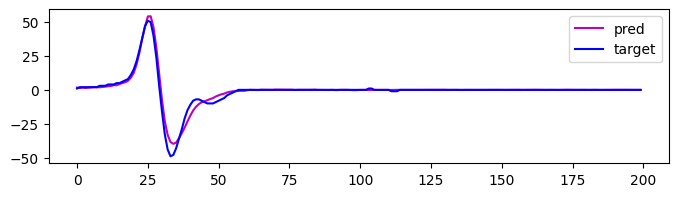

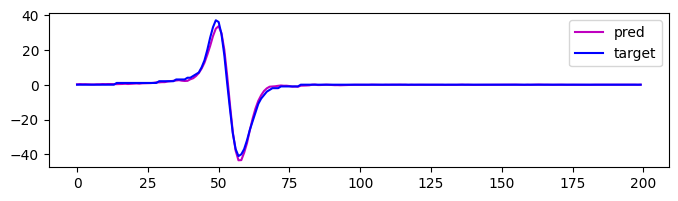

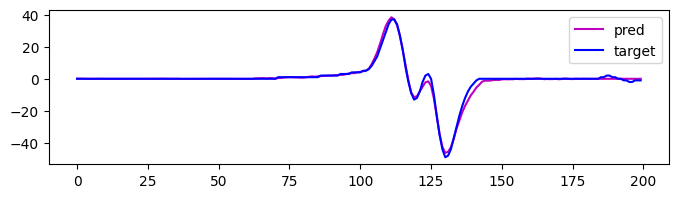

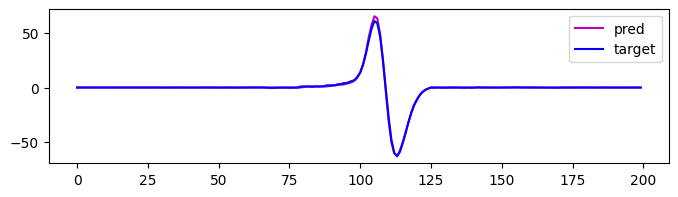

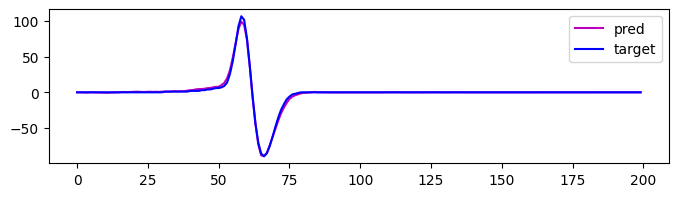

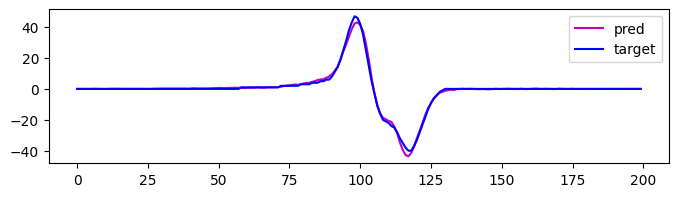

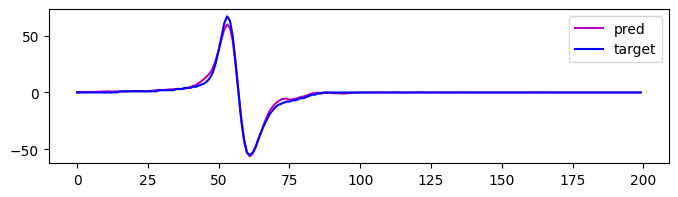

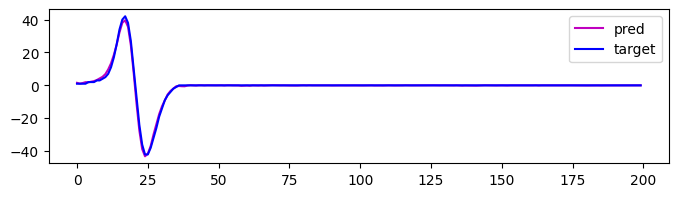

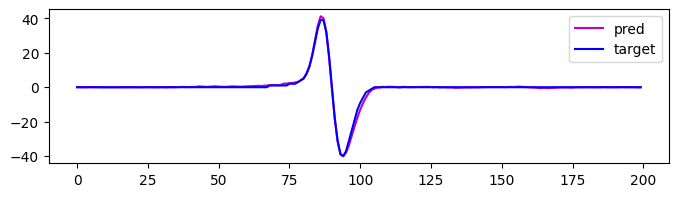

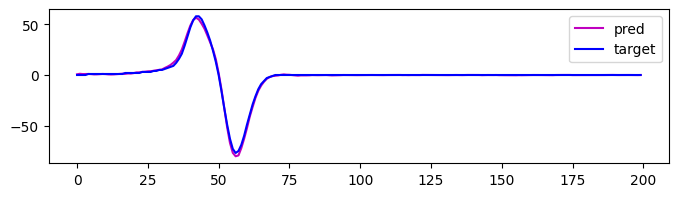

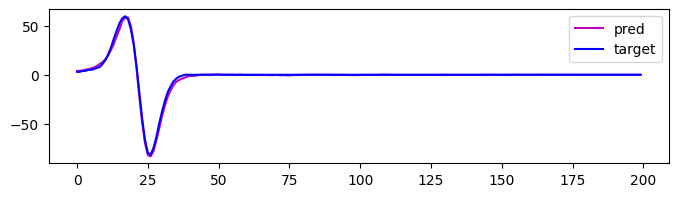

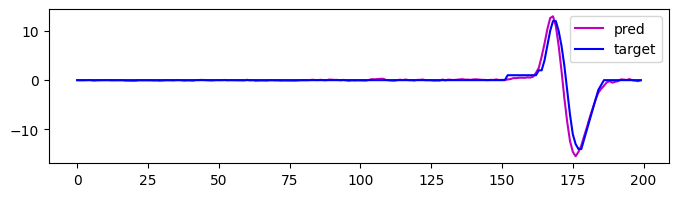

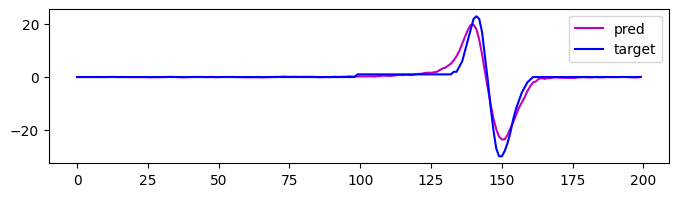

In [47]:
roi_ae(all_waveforms_nu_ES, 0,model_60k, model_AE_check, [model_60k_mean, model_60k_std], [mean_check, std_check],100)